<a href="https://colab.research.google.com/github/SBoo9/AI_Image_Generation_Segmentation/blob/main/ai_image_generation_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffusers transformers accelerate torch torchvision
!pip install opencv-python-headless pillow numpy matplotlib
!pip install rembg segment-anything-py
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import PIL
print(PIL.__version__)


11.3.0


In [ ]:
pip install --upgrade diffusers transformers accelerate safetensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 102.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.0
    Uninstalling transformers-4.55.0:
      Successfully uninstalled transformers-4.55.0


In [ ]:
! pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.0 MB/s eta 0:00:00


In [ ]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from PIL import Image, ImageFilter, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
from rembg import remove, new_session
import io
from sklearn.cluster import KMeans
from scipy import ndimage
from skimage import filters, morphology, measure

In [ ]:
from skimage.exposure import match_histograms
from skimage import exposure


In [ ]:
class EnhancedConfig:
    """Enhanced configuration with quality-focused parameters"""


    # Model settings
    STABLE_DIFFUSION_MODEL = "runwayml/stable-diffusion-v1-5"
    CONTROLNET_MODEL = "lllyasviel/sd-controlnet-canny"
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


    # Generation settings
    IMAGE_SIZE = 768  # Higher resolution for better quality
    NUM_INFERENCE_STEPS = 75  # More steps for quality
    GUIDANCE_SCALE = 9.0  # Higher guidance for better adherence


    # Advanced segmentation settings
    SEGMENTATION_MODEL = "u2net"
    REFINEMENT_ITERATIONS = 3
    EDGE_THRESHOLD = 0.1


    # Enhanced blending settings
    SHADOW_INTENSITY = 0.35
    SHADOW_BLUR_RADIUS = 20
    EDGE_FEATHER_RADIUS = 5
    COLOR_ADAPTATION_STRENGTH = 0.25
    LIGHTING_ADAPTATION_STRENGTH = 0.2


    # Quality matching settings
    HISTOGRAM_MATCH_STRENGTH = 0.3
    NOISE_MATCH_STRENGTH = 0.2
    CONTRAST_MATCH_STRENGTH = 0.4


config = EnhancedConfig()


In [ ]:
class EnhancedObjectGenerator:
    """
    Enhanced generator with quality analysis and adaptive prompting
    """


    def __init__(self):
        print("Loading enhanced Stable Diffusion model...")
        self.pipe = StableDiffusionPipeline.from_pretrained(
            config.STABLE_DIFFUSION_MODEL,
            torch_dtype=torch.float16 if config.DEVICE == "cuda" else torch.float32,
            safety_checker=None,
            requires_safety_checker=False
        )


        self.pipe.scheduler = DPMSolverMultistepScheduler.from_config(
            self.pipe.scheduler.config
        )
        self.pipe = self.pipe.to(config.DEVICE)


        #if config.DEVICE == "cuda":
        #   self.pipe.enable_memory_efficient_attention()
        #   try:
        #       self.pipe.enable_xformers_memory_efficient_attention()
        #   except:
        #       print("xformers not available, using standard attention")


        print("Enhanced model loaded successfully!")


    def generate_object(self, prompt, background_image=None, seed=None):
        """
        Generate object with background-aware quality matching
        """
        # Analyze background if provided
        background_analysis = None
        if background_image is not None:
            background_analysis = self._analyze_background(background_image)


        # Create quality-matched prompt
        enhanced_prompt = self._create_quality_prompt(prompt, background_analysis)
        negative_prompt = self._create_negative_prompt(background_analysis)


        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)


        print(f"Generating with enhanced prompt: {enhanced_prompt[:100]}...")


        with torch.autocast(config.DEVICE):
            image = self.pipe(
                enhanced_prompt,
                negative_prompt=negative_prompt,
                num_inference_steps=config.NUM_INFERENCE_STEPS,
                guidance_scale=config.GUIDANCE_SCALE,
                width=config.IMAGE_SIZE,
                height=config.IMAGE_SIZE
            ).images[0]


        return image


    def _analyze_background(self, background):
        """Analyze background characteristics for quality matching"""
        bg_array = np.array(background)


        analysis = {
            'brightness': np.mean(bg_array),
            'contrast': np.std(bg_array),
            'color_temperature': self._estimate_color_temperature(bg_array),
            'dominant_colors': self._get_dominant_colors(bg_array),
            'noise_level': self._estimate_noise_level(bg_array),
            'sharpness': self._estimate_sharpness(bg_array)
        }


        return analysis


    def _estimate_color_temperature(self, image):
        """Estimate color temperature of image"""
        avg_color = np.mean(image, axis=(0, 1))
        # Simple color temperature estimation
        if avg_color[2] > avg_color[0]:  # More blue than red
            return "cool"
        elif avg_color[0] > avg_color[2]:  # More red than blue
            return "warm"
        else:
            return "neutral"


    def _get_dominant_colors(self, image, n_colors=3):
        """Extract dominant colors using K-means"""
        pixels = image.reshape(-1, 3)
        kmeans = KMeans(n_clusters=n_colors, random_state=42, n_init=10)
        kmeans.fit(pixels)
        return kmeans.cluster_centers_


    def _estimate_noise_level(self, image):
        """Estimate noise level in image"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        noise = cv2.Laplacian(gray, cv2.CV_64F).var()
        return "high" if noise > 500 else "medium" if noise > 100 else "low"


    def _estimate_sharpness(self, image):
        """Estimate image sharpness"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
        return "sharp" if sharpness > 1000 else "medium" if sharpness > 300 else "soft"


    def _create_quality_prompt(self, base_prompt, bg_analysis):
        """Create quality-matched prompt based on background analysis"""
        quality_terms = [
            "photorealistic", "high quality", "detailed", "professional photography",
            "realistic background", "natural lighting"
            ]


        if bg_analysis:
            # Add style terms based on background
            if bg_analysis['color_temperature'] == "warm":
                quality_terms.append("warm lighting")
            elif bg_analysis['color_temperature'] == "cool":
                quality_terms.append("cool lighting")


            if bg_analysis['sharpness'] == "sharp":
                quality_terms.append("sharp focus")
            elif bg_analysis['sharpness'] == "soft":
                quality_terms.append("soft focus")


            brightness = bg_analysis['brightness']
            if brightness > 150:
                quality_terms.append("bright lighting")
            elif brightness < 100:
                quality_terms.append("dramatic lighting")


        enhanced_prompt = f"{base_prompt}, {', '.join(quality_terms)}"
        return enhanced_prompt


    def _create_negative_prompt(self, bg_analysis):
        """Create adaptive negative prompt"""
        negative_terms = [
            "blurry", "low quality", "distorted", "deformed", "multiple objects",
            "background", "cluttered", "text", "watermark", "signature", "frame",
            "oversaturated", "undersaturated", "noise", "artifacts"
        ]


        if bg_analysis:
            if bg_analysis['noise_level'] == "low":
                negative_terms.append("grainy")
            if bg_analysis['sharpness'] == "sharp":
                negative_terms.append("soft")


        return ", ".join(negative_terms)


In [ ]:
class PrecisionSegmenter:
    """
    Enhanced segmentation with multiple models and refinement
    """


    def __init__(self):
        print("Initializing precision segmentation models...")
        # Primary segmentation model
        self.primary_session = new_session("u2net")
        # Backup segmentation model
        self.backup_session = new_session("silueta")
        print("Segmentation models ready!")


    def segment_object(self, image, refinement_level="high"):
        """
        Multi-stage precision segmentation
        """
        # Stage 1: Primary segmentation
        primary_result = self._segment_with_rembg(image, self.primary_session)


        # Stage 2: Refinement and validation
        refined_mask = self._refine_mask(primary_result['mask'], image)


        # Stage 3: Edge enhancement
        enhanced_mask = self._enhance_edges(refined_mask, image)


        # Stage 4: Quality validation and fallback
        if self._validate_segmentation_quality(enhanced_mask) < 0.7:
            print("Primary segmentation quality low, trying backup method...")
            backup_result = self._segment_with_rembg(image, self.backup_session)
            enhanced_mask = self._enhance_edges(backup_result['mask'], image)


        # Create final segmented object
        segmented_object = self._apply_mask_to_image(image, enhanced_mask)


        return segmented_object, enhanced_mask


    def _segment_with_rembg(self, image, session):
        """Segment using rembg with specified session"""
        img_byte_arr = io.BytesIO()
        image.save(img_byte_arr, format='PNG')
        img_byte_arr = img_byte_arr.getvalue()


        output = remove(img_byte_arr, session=session)
        segmented_image = Image.open(io.BytesIO(output))


        if segmented_image.mode == 'RGBA':
            mask = segmented_image.split()[-1]
        else:
            mask = self._create_mask_from_difference(image, segmented_image)


        return {'segmented': segmented_image, 'mask': mask}


    def _refine_mask(self, mask, original_image):
        """Advanced mask refinement"""
        mask_array = np.array(mask)


        # Convert to binary
        binary_mask = (mask_array > 128).astype(np.uint8)


        # Morphological operations
        kernel_small = np.ones((3, 3), np.uint8)
        kernel_large = np.ones((5, 5), np.uint8)


        # Remove small noise
        cleaned = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel_small)


        # Fill holes
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel_large)


        # Fill remaining holes using flood fill
        cleaned = ndimage.binary_fill_holes(cleaned).astype(np.uint8)


        # Smooth boundaries
        cleaned = cv2.medianBlur(cleaned, 5)


        return Image.fromarray(cleaned * 255)


    def _enhance_edges(self, mask, original_image):
        """Enhance mask edges using image gradients"""
        mask_array = np.array(mask)
        img_array = np.array(original_image.convert('L'))


        # Calculate image gradients
        grad_x = cv2.Sobel(img_array, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(img_array, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)


        # Normalize gradient
        gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX)


        # Find mask edges
        mask_edges = cv2.Canny(mask_array, 50, 150)


        # Dilate edges to create search region
        search_kernel = np.ones((7, 7), np.uint8)
        search_region = cv2.dilate(mask_edges, search_kernel, iterations=1)


        # Find strong gradients in search region
        strong_edges = (gradient_magnitude > np.percentile(gradient_magnitude, 70)) & (search_region > 0)


        # Refine mask edges
        refined_mask = mask_array.copy()
        edge_pixels = np.where(strong_edges)


        # Apply refined edges with distance weighting
        for y, x in zip(edge_pixels[0], edge_pixels[1]):
            if mask_array[y, x] > 0:  # Only refine existing mask areas
                gradient_strength = gradient_magnitude[y, x] / 255.0
                refined_mask[y, x] = int(mask_array[y, x] * (0.7 + 0.3 * gradient_strength))


        return Image.fromarray(refined_mask.astype(np.uint8))


    def _validate_segmentation_quality(self, mask):
        """Validate segmentation quality using multiple metrics"""
        mask_array = np.array(mask)


        # Check mask coverage (should not be too small or too large)
        coverage = np.sum(mask_array > 128) / mask_array.size
        coverage_score = 1.0 if 0.05 <= coverage <= 0.8 else 0.5


        # Check mask connectivity (prefer single connected component)
        binary_mask = (mask_array > 128).astype(np.uint8)
        num_labels, _ = cv2.connectedComponents(binary_mask)
        connectivity_score = 1.0 if num_labels <= 3 else 0.7  # Allow 1-2 components


        # Check edge smoothness
        edges = cv2.Canny(mask_array, 50, 150)
        edge_smoothness = 1.0 - (np.sum(edges) / (mask_array.size * 255))


        overall_score = (coverage_score + connectivity_score + edge_smoothness) / 3
        return overall_score


    def _apply_mask_to_image(self, image, mask):
        """Apply mask to create segmented object"""
        segmented = Image.new('RGBA', image.size, (0, 0, 0, 0))
        segmented.paste(image, mask=mask)
        return segmented


    def _create_mask_from_difference(self, original, processed):
        """Create mask from image difference when alpha not available"""
        orig_array = np.array(original.convert('RGB'))
        proc_array = np.array(processed.convert('RGB'))


        # Calculate difference
        diff = np.sum(np.abs(orig_array - proc_array), axis=2)


        # Threshold to create mask
        threshold = np.percentile(diff, 50)
        mask = (diff < threshold).astype(np.uint8) * 255


        return Image.fromarray(mask)

In [ ]:
class IntelligentPlacer:
    """
    Smart object placement with perspective and composition awareness
    """


    def __init__(self):
        pass


    def place_object(self, obj_image, obj_mask, background, position=None,
                    scale=None, auto_scale=True, perspective_correct=True):
        """
        Intelligent object placement with automatic scaling and perspective
        """
        if position is None:
            position = self._find_optimal_position(background, obj_mask)


        if scale is None or auto_scale:
            scale = self._calculate_optimal_scale(obj_image, background, position)


        # Apply perspective correction if enabled
        if perspective_correct:
            obj_image, obj_mask = self._apply_perspective_correction(
                obj_image, obj_mask, background, position
            )


        # Resize object and mask
        if scale != 1.0:
            new_size = (
                int(obj_image.width * scale),
                int(obj_image.height * scale)
            )
            obj_image = obj_image.resize(new_size, Image.Resampling.LANCZOS)
            obj_mask = obj_mask.resize(new_size, Image.Resampling.LANCZOS)


        # Calculate placement position
        x, y = position
        paste_x = max(0, min(x - obj_image.width // 2, background.width - obj_image.width))
        paste_y = max(0, min(y - obj_image.height // 2, background.height - obj_image.height))


        # Create composite
        composite = background.copy()
        placed_mask = Image.new('L', background.size, 0)
        placed_mask.paste(obj_mask, (paste_x, paste_y))


        # Smart pasting with alpha blending
        if obj_image.mode == 'RGBA':
            composite.paste(obj_image, (paste_x, paste_y), obj_mask)
        else:
            composite.paste(obj_image, (paste_x, paste_y), obj_mask)


        return composite, placed_mask, {'scale': scale, 'position': (paste_x, paste_y)}


    def _find_optimal_position(self, background, obj_mask):
        """Find optimal position using composition rules"""
        bg_array = np.array(background.convert('L'))


        # Find areas with low gradient (smooth areas)
        gradient = cv2.Laplacian(bg_array, cv2.CV_64F)
        smooth_areas = (np.abs(gradient) < np.percentile(np.abs(gradient), 30))


        # Apply rule of thirds
        h, w = bg_array.shape
        third_points = [
            (w//3, h//3), (2*w//3, h//3),
            (w//3, 2*h//3), (2*w//3, 2*h//3),
            (w//2, h//2)  # Center as fallback
        ]


        # Score each position
        obj_h, obj_w = np.array(obj_mask).shape
        best_score = -1
        best_position = (w//2, h//2)


        for x, y in third_points:
            # Check if object fits
            if (x - obj_w//2 >= 0 and x + obj_w//2 < w and
                y - obj_h//2 >= 0 and y + obj_h//2 < h):


                # Score based on smoothness in placement area
                area = smooth_areas[y-obj_h//2:y+obj_h//2, x-obj_w//2:x+obj_w//2]
                smoothness_score = np.mean(area)


                if smoothness_score > best_score:
                    best_score = smoothness_score
                    best_position = (x, y)


        return best_position


    def _calculate_optimal_scale(self, obj_image, background, position):
        """Calculate optimal scale based on perspective and composition"""
        # Basic scale calculation based on image sizes
        bg_area = background.width * background.height
        obj_area = obj_image.width * obj_image.height


        # Target object to occupy 5-20% of background
        target_ratio = 0.12
        current_ratio = obj_area / bg_area


        scale = np.sqrt(target_ratio / current_ratio)


        # Clamp scale to reasonable range
        scale = np.clip(scale, 0.3, 2.0)


        return scale


    def _apply_perspective_correction(self, obj_image, obj_mask, background, position):
        """Apply subtle perspective correction based on position"""
        # Simple perspective effect based on vertical position
        bg_height = background.height
        y_position = position[1]


        # Objects lower in image appear slightly larger (closer)
        perspective_factor = 1.0 + (y_position / bg_height - 0.5) * 0.1


        if abs(perspective_factor - 1.0) > 0.02:  # Only apply if significant
            new_width = int(obj_image.width * perspective_factor)
            new_height = int(obj_image.height * perspective_factor)


            obj_image = obj_image.resize((new_width, new_height), Image.Resampling.LANCZOS)
            obj_mask = obj_mask.resize((new_width, new_height), Image.Resampling.LANCZOS)


        return obj_image, obj_mask


In [ ]:
class AdvancedBlender:
    """
    Advanced blending with lighting analysis and quality matching
    """


    def __init__(self):
        pass


    def blend_object(self, composite, obj_mask, background, placement_info):
        """
        Advanced blending with multiple quality enhancement stages
        """
        # Convert to numpy arrays
        composite_array = np.array(composite).astype(np.float32)
        mask_array = np.array(obj_mask).astype(np.float32) / 255.0
        background_array = np.array(background).astype(np.float32)


        # Stage 1: Lighting analysis and matching
        lit_composite = self._match_lighting_advanced(
            composite_array, mask_array, background_array
        )


        # Stage 2: Color harmony adjustment
        harmonized_composite = self._enhance_color_harmony(
            lit_composite, mask_array, background_array
        )


        # Stage 3: Advanced shadow generation
        shadow_composite = self._generate_advanced_shadows(
            harmonized_composite, mask_array, background_array, placement_info
        )


        # Stage 4: Quality matching (noise, contrast, sharpness)
        quality_matched = self._match_image_quality(
            shadow_composite, mask_array, background_array
        )


        # Stage 5: Edge integration
        final_composite = self._integrate_edges(
            quality_matched, mask_array, background_array
        )
        final_composite = exposure.rescale_intensity(final_composite, in_range='image', out_range=(0, 255))
        return Image.fromarray(np.clip(final_composite, 0, 255).astype(np.uint8))


    def _match_lighting_advanced(self, composite, mask, background):
        """Advanced lighting matching using multiple techniques"""
        result = composite.copy()


        # Extract object and background regions
        object_region = composite * np.expand_dims(mask, axis=2)
        background_region = background * np.expand_dims(1 - mask, axis=2)


        # Calculate lighting statistics
        bg_mean = np.mean(background_region[background_region > 0].reshape(-1, 3), axis=0)
        bg_std = np.std(background_region[background_region > 0].reshape(-1, 3), axis=0)


        obj_pixels = object_region[mask > 0.1]
        if len(obj_pixels) > 0:
            obj_mean = np.mean(obj_pixels, axis=0)
            obj_std = np.std(obj_pixels, axis=0)


            # Brightness matching
            brightness_ratio = bg_mean / (obj_mean + 1e-6)
            brightness_adjustment = np.clip(
                1 + (brightness_ratio - 1) * config.LIGHTING_ADAPTATION_STRENGTH,0.85, 1.15)


            # Contrast matching
            contrast_ratio = bg_std / (obj_std + 1e-6)
            contrast_diff = abs(np.std(obj_pixels) - np.std(background_region[background_region > 0].reshape(-1, 3)))
            if contrast_diff > 40:
              brightness_adjustment = np.clip(brightness_adjustment, 0.95, 1.05)


            # Apply adjustments
            mask_3d = np.expand_dims(mask, axis=2)
            for c in range(3):
                obj_channel = result[:, :, c] * mask_3d[:, :, 0]


                # Brightness adjustment
                obj_channel = obj_channel * brightness_adjustment[c]


                # Contrast adjustment (simple version)
                obj_mean_current = np.mean(obj_channel[mask > 0.1])
                obj_channel = obj_mean_current + (obj_channel - obj_mean_current) * contrast_ratio[c] * 0.5


                result[:, :, c] = result[:, :, c] * (1 - mask_3d[:, :, 0]) + obj_channel
        matched = match_histograms(
            (result * mask_3d).astype(np.uint8),
            (background * (1 - mask_3d)).astype(np.uint8),
            channel_axis=-1)
        result = (result * 0.5 + matched.astype(np.float32) * 0.5)
        return result


    def _enhance_color_harmony(self, composite, mask, background):
        """Enhance color harmony between object and background"""
        result = composite.copy()


        # Calculate dominant colors
        bg_colors = self._extract_dominant_colors(background, num_colors=3)


        # Apply subtle color shift towards background palette
        mask_3d = np.expand_dims(mask, axis=2)
        object_region = composite * mask_3d


        if np.sum(mask) > 0:
            # Find closest background color for each object pixel
            obj_pixels = object_region[mask > 0.1]


            for i, bg_color in enumerate(bg_colors):
                # Calculate color distance
                distances = np.linalg.norm(obj_pixels - bg_color, axis=1)


                # Apply color shift to closest pixels
                close_pixels = distances < 100  # Threshold for "close" colors
                if np.sum(close_pixels) > 0:
                    shift_strength = config.COLOR_ADAPTATION_STRENGTH * 0.3
                    obj_pixels[close_pixels] = (
                        obj_pixels[close_pixels] * (1 - shift_strength) +
                        bg_color * shift_strength
                    )


            # Put modified pixels back
            object_region[mask > 0.1] = obj_pixels
            result = result * (1 - mask_3d) + object_region


        return result


    def _generate_advanced_shadows(self, composite, mask, background, placement_info):
        """Generate realistic shadows with multiple light sources"""
        result = composite.copy()


        # Primary shadow (main light source)
        primary_shadow = self._create_shadow(
            mask, offset=(15, 20), blur_radius=config.SHADOW_BLUR_RADIUS,
            intensity=config.SHADOW_INTENSITY
        )


        # Secondary shadow (ambient light)
        secondary_shadow = self._create_shadow(
            mask, offset=(5, 8), blur_radius=config.SHADOW_BLUR_RADIUS // 2,
            intensity=config.SHADOW_INTENSITY * 0.3
        )


        # Combine shadows
        combined_shadow = np.maximum(primary_shadow, secondary_shadow)


        # Remove shadow where object exists
        object_mask_3d = np.expand_dims(mask, axis=2)
        combined_shadow = combined_shadow * (1 - object_mask_3d)


        # Apply shadow to background
        result = result * (1 - combined_shadow) + background * combined_shadow * 0.7


        return result


    def _create_shadow(self, mask, offset, blur_radius, intensity):
        """Create a single shadow with specified parameters"""
        shadow_mask = mask.copy()


        # Shift shadow
        shadow_mask = np.roll(shadow_mask, offset[1], axis=0)
        shadow_mask = np.roll(shadow_mask, offset[0], axis=1)


        # Blur shadow
        shadow_mask = cv2.GaussianBlur(shadow_mask, (blur_radius*2+1, blur_radius*2+1), 0)


        # Apply intensity
        shadow_mask = shadow_mask * intensity


        return np.expand_dims(shadow_mask, axis=2)


    def _match_image_quality(self, composite, mask, background):
        """Match noise, contrast, and sharpness characteristics"""
        result = composite.copy()


        # Estimate background characteristics
        bg_noise = self._estimate_noise_characteristics(background)
        bg_sharpness = self._estimate_sharpness_characteristics(background)


        # Apply to object region
        mask_3d = np.expand_dims(mask, axis=2)
        object_region = composite * mask_3d


        if np.sum(mask) > 0:
            # Add noise to match background
            if config.NOISE_MATCH_STRENGTH > 0:
                noise = np.random.normal(0, bg_noise * config.NOISE_MATCH_STRENGTH, object_region.shape)
                object_region = object_region + noise * mask_3d


            # Adjust sharpness
            if bg_sharpness < 0.5:  # Background is soft, soften object
                kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) * 0.5
                for c in range(3):
                    object_channel = object_region[:, :, c]
                    sharpened = cv2.filter2D(object_channel, -1, kernel)
                    object_region[:, :, c] = object_channel * 0.7 + sharpened * 0.3


            result = result * (1 - mask_3d) + object_region


        return result


    def _integrate_edges(self, composite, mask, background):
        """Advanced edge integration for seamless blending"""
        result = composite.copy()


        # Create multi-level edge masks
        edge_masks = []
        for radius in [2, 5, 10]:
            kernel = np.ones((radius*2+1, radius*2+1), np.uint8)
            eroded = cv2.erode((mask * 255).astype(np.uint8), kernel, iterations=1)
            edge_mask = mask - eroded.astype(np.float32) / 255.0
            edge_mask = cv2.GaussianBlur(edge_mask, (radius*2+1, radius*2+1), 0)
            edge_masks.append(edge_mask)


        # Apply progressive blending
        for i, edge_mask in enumerate(edge_masks):
            edge_mask_3d = np.expand_dims(edge_mask, axis=2)
            blur_strength = 0.3 + i * 0.02


            # Create blurred version
            blurred = cv2.GaussianBlur(result, (3, 3), 0)


            # Blend with original
            result = result * (1 - edge_mask_3d * blur_strength) + blurred * (edge_mask_3d * blur_strength)


        return result


    def _extract_dominant_colors(self, image, num_colors=3):
        """Extract dominant colors using improved K-means"""
        pixels = image.reshape(-1, 3)
        # Remove very dark and very bright pixels for better color analysis
        valid_pixels = pixels[(pixels.mean(axis=1) > 20) & (pixels.mean(axis=1) < 235)]


        if len(valid_pixels) > 0:
            kmeans = KMeans(n_clusters=num_colors, random_state=42, n_init=10)
            kmeans.fit(valid_pixels)
            return kmeans.cluster_centers_
        else:
            return np.array([[128, 128, 128]] * num_colors)  # Fallback to gray


    def _estimate_noise_characteristics(self, image):
        """Estimate noise characteristics of image"""
        gray = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2GRAY)


        # Use Laplacian variance as noise estimate
        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()


        # Normalize to reasonable range
        noise_level = min(laplacian_var / 1000.0, 10.0)
        return noise_level


    def _estimate_sharpness_characteristics(self, image):
        """Estimate sharpness characteristics"""
        gray = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2GRAY)


        # Calculate focus measure using variance of Laplacian
        focus_measure = cv2.Laplacian(gray, cv2.CV_64F).var()


        # Normalize to 0-1 range
        sharpness = min(focus_measure / 2000.0, 1.0)
        return sharpness




In [ ]:
class QualityAssessor:
    """
    Assess and improve blending quality using perceptual metrics
    """


    def __init__(self):
        pass


    def assess_blend_quality(self, final_image, background, object_mask):
        """
        Comprehensive quality assessment
        """
        scores = {}


        # Edge quality assessment
        scores['edge_quality'] = self._assess_edge_quality(final_image, object_mask)


        # Color harmony assessment
        scores['color_harmony'] = self._assess_color_harmony(final_image, background, object_mask)


        # Lighting consistency assessment
        scores['lighting_consistency'] = self._assess_lighting_consistency(final_image, background, object_mask)


        # Shadow realism assessment
        scores['shadow_realism'] = self._assess_shadow_realism(final_image, background, object_mask)


        # Overall quality score
        weights = {
            'edge_quality': 0.3,
            'color_harmony': 0.25,
            'lighting_consistency': 0.25,
            'shadow_realism': 0.2
        }


        scores['overall'] = sum(scores[key] * weights[key] for key in weights)


        return scores


    def _assess_edge_quality(self, image, mask):
        """Assess edge integration quality"""
        img_array = np.array(image)
        mask_array = np.array(mask)


        # Find edge pixels
        edges = cv2.Canny((mask_array).astype(np.uint8), 50, 150)
        edge_pixels = np.where(edges > 0)


        if len(edge_pixels[0]) == 0:
            return 0.5


        # Calculate gradient discontinuity at edges
        gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        gradient_mag = np.sqrt(grad_x**2 + grad_y**2)


        # Sample gradient at edge pixels
        edge_gradients = gradient_mag[edge_pixels]


        # Lower gradients at edges indicate better blending
        avg_edge_gradient = np.mean(edge_gradients)


        # Normalize score (lower gradient = higher score)
        score = max(0, 1 - avg_edge_gradient / 100)
        return score


    def _assess_color_harmony(self, image, background, mask):
        """Assess color harmony between object and background"""
        img_array = np.array(image)
        bg_array = np.array(background)
        mask_array = np.array(mask) / 255.0


        # Extract object and background colors
        obj_pixels = img_array[mask_array > 0.5]
        bg_pixels = bg_array[mask_array < 0.5]


        if len(obj_pixels) == 0 or len(bg_pixels) == 0:
            return 0.5


        # Calculate color distribution similarity
        obj_hist = np.histogram2d(obj_pixels[:, 0], obj_pixels[:, 1], bins=32)[0]
        bg_hist = np.histogram2d(bg_pixels[:, 0], bg_pixels[:, 1], bins=32)[0]


        # Normalize histograms
        obj_hist = obj_hist / (np.sum(obj_hist) + 1e-6)
        bg_hist = bg_hist / (np.sum(bg_hist) + 1e-6)


        # Calculate histogram correlation
        correlation = np.corrcoef(obj_hist.flatten(), bg_hist.flatten())[0, 1]


        # Convert correlation to score (higher correlation = better harmony)
        score = max(0, (correlation + 1) / 2)  # Convert from [-1,1] to [0,1]
        return score


    def _assess_lighting_consistency(self, image, background, mask):
        """Assess lighting consistency"""
        img_array = np.array(image)
        bg_array = np.array(background)
        mask_array = np.array(mask) / 255.0


        # Calculate brightness distribution
        obj_brightness = np.mean(img_array[mask_array > 0.5], axis=1) if np.sum(mask_array > 0.5) > 0 else np.array([128])
        bg_brightness = np.mean(bg_array[mask_array < 0.5], axis=1) if np.sum(mask_array < 0.5) > 0 else np.array([128])


        # Calculate brightness similarity
        obj_mean_brightness = np.mean(obj_brightness)
        bg_mean_brightness = np.mean(bg_brightness)


        brightness_diff = abs(obj_mean_brightness - bg_mean_brightness)


        # Convert to score (smaller difference = higher score)
        score = max(0, 1 - brightness_diff / 255)
        return score


    def _assess_shadow_realism(self, image, background, mask):
        """Assess shadow realism"""
        # Simple shadow detection and assessment
        img_array = np.array(image)
        bg_array = np.array(background)
        mask_array = np.array(mask) / 255.0


        # Look for darkened areas near object (potential shadows)
        shadow_candidates = (img_array.mean(axis=2) < bg_array.mean(axis=2) - 10) & (mask_array < 0.1)


        if np.sum(shadow_candidates) == 0:
            return 0.3  # No shadows detected, moderate score


        # Assess shadow properties
        shadow_area_ratio = np.sum(shadow_candidates) / np.sum(mask_array > 0.5)


        # Ideal shadow area is 20-80% of object area
        if 0.2 <= shadow_area_ratio <= 0.4:
            score = 0.8
        else:
            score = 0.5


        return score


In [ ]:
class EnhancedObjectBlendingPipeline:
    """
    Complete enhanced pipeline with quality assessment and iterative improvement
    """


    def __init__(self):
        print("Initializing Enhanced Object Blending Pipeline...")
        self.generator = EnhancedObjectGenerator()
        self.segmenter = PrecisionSegmenter()
        self.placer = IntelligentPlacer()
        self.blender = AdvancedBlender()
        self.assessor = QualityAssessor()
        print("Enhanced pipeline ready!")


    def process(self, text_prompt, background_path, position=None, scale=None,
                seed=None, quality_iterations=2):
        """
        Enhanced processing with quality assessment and iterative improvement
        """
        results = {}


        # Step 1: Load and analyze background
        print("Step 1: Loading and analyzing background...")
        background = Image.open(background_path).convert('RGB')
        results['background'] = background


        # Step 2: Generate quality-matched object
        print("Step 2: Generating quality-matched object...")
        generated_obj = self.generator.generate_object(
            text_prompt, background_image=background, seed=seed
        )
        results['generated_object'] = generated_obj


        # Step 3: Precision segmentation
        print("Step 3: Performing precision segmentation...")
        segmented_obj, obj_mask = self.segmenter.segment_object(generated_obj)
        results['segmented_object'] = segmented_obj
        results['object_mask'] = obj_mask


        # Step 4: Intelligent placement
        print("Step 4: Intelligent object placement...")
        composite, placed_mask, placement_info = self.placer.place_object(
            segmented_obj, obj_mask, background, position, scale
        )
        results['composite'] = composite
        results['placed_mask'] = placed_mask
        results['placement_info'] = placement_info


        # Step 5: Advanced blending with iterative improvement
        print("Step 5: Advanced blending...")
        current_result = composite


        for iteration in range(quality_iterations):
            print(f"  Blending iteration {iteration + 1}/{quality_iterations}...")


            blended_result = self.blender.blend_object(
                current_result, placed_mask, background, placement_info
            )


            # Assess quality
            quality_scores = self.assessor.assess_blend_quality(
                blended_result, background, placed_mask
            )


            print(f"  Quality score: {quality_scores['overall']:.3f}")


            # Store iteration result
            results[f'iteration_{iteration + 1}'] = blended_result
            results[f'quality_scores_{iteration + 1}'] = quality_scores


            current_result = blended_result


        results['final_result'] = current_result
        results['final_quality_scores'] = quality_scores


        print("Enhanced pipeline complete!")
        return results


    def visualize_enhanced_results(self, results, figsize=(24, 16)):
        """Enhanced visualization with quality metrics"""


        num_iterations = sum(1 for key in list(results.keys()) if key.startswith('iteration_'))


        fig, axes = plt.subplots(3, 4, figsize=figsize)


        # Row 1: Generation and segmentation
        axes[0, 0].imshow(results['background'])
        axes[0, 0].set_title('Background', fontsize=12, fontweight='bold')
        axes[0, 0].axis('off')


        axes[0, 1].imshow(results['generated_object'])
        axes[0, 1].set_title('Generated Object', fontsize=12, fontweight='bold')
        axes[0, 1].axis('off')


        axes[0, 2].imshow(results['segmented_object'])
        axes[0, 2].set_title('Segmented Object', fontsize=12, fontweight='bold')
        axes[0, 2].axis('off')


        axes[0, 3].imshow(results['object_mask'], cmap='gray')
        axes[0, 3].set_title('Precision Mask', fontsize=12, fontweight='bold')
        axes[0, 3].axis('off')


        # Row 2: Placement and iterations
        axes[1, 0].imshow(results['composite'])
        axes[1, 0].set_title('Initial Placement', fontsize=12, fontweight='bold')
        axes[1, 0].axis('off')


        # Show up to 3 iterations
        for i in range(min(3, num_iterations)):
            if f'iteration_{i + 1}' in results:
                axes[1, i + 1].imshow(results[f'iteration_{i + 1}'])
                quality = results[f'quality_scores_{i + 1}']['overall']
                axes[1, i + 1].set_title(f'Iteration {i + 1}\nQuality: {quality:.3f}',
                                        fontsize=12, fontweight='bold')
                axes[1, i + 1].axis('off')


        # Row 3: Final result and quality breakdown
        axes[2, 0].imshow(results['final_result'])
        final_quality = results['final_quality_scores']['overall']
        axes[2, 0].set_title(f'Final Result\nOverall Quality: {final_quality:.3f}',
                            fontsize=12, fontweight='bold')
        axes[2, 0].axis('off')


        # Quality metrics visualization
        if 'final_quality_scores' in results:
            scores = results['final_quality_scores']
            metrics = ['edge_quality', 'color_harmony', 'lighting_consistency', 'shadow_realism']
            values = [scores[metric] for metric in metrics]


            axes[2, 1].bar(range(len(metrics)), values, color='skyblue')
            axes[2, 1].set_xticks(range(len(metrics)))
            axes[2, 1].set_xticklabels([m.replace('_', '\n') for m in metrics], fontsize=10)
            axes[2, 1].set_ylim(0, 1)
            axes[2, 1].set_title('Quality Metrics', fontsize=12, fontweight='bold')
            axes[2, 1].grid(True, alpha=0.3)


        # Hide unused subplots
        for i in range(2, 4):
            axes[2, i].axis('off')


        plt.tight_layout()
        plt.show()


    def generate_quality_report(self, results):
        """Generate detailed quality report"""
        if 'final_quality_scores' not in results:
            print("No quality scores available for report generation.")
            return


        scores = results['final_quality_scores']


        print("\n" + "="*60)
        print("ENHANCED PIPELINE QUALITY REPORT")
        print("="*60)


        print(f"\nOVERALL QUALITY SCORE: {scores['overall']:.3f}/1.000")


        print(f"\nDETAILED METRICS:")
        print(f"├─ Edge Quality:           {scores['edge_quality']:.3f}")
        print(f"├─ Color Harmony:          {scores['color_harmony']:.3f}")
        print(f"├─ Lighting Consistency:   {scores['lighting_consistency']:.3f}")
        print(f"└─ Shadow Realism:         {scores['shadow_realism']:.3f}")


        # Quality interpretation
        overall = scores['overall']
        if overall >= 0.8:
            quality_level = "EXCELLENT"
            interpretation = "Outstanding integration with natural appearance"
        elif overall >= 0.6:
            quality_level = "GOOD"
            interpretation = "High quality blending with minor artifacts"
        elif overall >= 0.4:
            quality_level = "FAIR"
            interpretation = "Acceptable blending with some visible seams"
        else:
            quality_level = "POOR"
            interpretation = "Significant blending issues detected"


        print(f"\nQUALITY ASSESSMENT: {quality_level}")
        print(f"Interpretation: {interpretation}")


        # Recommendations
        print(f"\nRECOMMENDations:")
        if scores['edge_quality'] < 0.6:
            print("• Consider adjusting edge feathering parameters")
        if scores['color_harmony'] < 0.6:
            print("• Increase color adaptation strength")
        if scores['lighting_consistency'] < 0.6:
            print("• Adjust lighting matching parameters")
        if scores['shadow_realism'] < 0.6:
            print("• Fine-tune shadow generation settings")


        if 'placement_info' in results:
            placement = results['placement_info']
            print(f"\nPLACEMENT INFO:")
            print(f"• Final scale: {placement['scale']:.2f}")
            print(f"• Position: {placement['position']}")



ENHANCED OBJECT BLENDING PIPELINE READY!

KEY IMPROVEMENTS:
✓ Quality-matched object generation
✓ Multi-stage precision segmentation
✓ Intelligent placement with perspective
✓ Advanced lighting and shadow analysis
✓ Iterative quality improvement
✓ Comprehensive quality assessment

QUICK START:
1. Upload background images to your environment
2. Update image paths in enhanced_demo()
3. Run: enhanced_demo()

CUSTOM USAGE:
pipeline = EnhancedObjectBlendingPipeline()
results = pipeline.process('your prompt', 'background.jpg')
pipeline.visualize_enhanced_results(results)
ENHANCED OBJECT BLENDING PIPELINE DEMO
Initializing Enhanced Object Blending Pipeline...
Loading enhanced Stable Diffusion model...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Enhanced model loaded successfully!
Initializing precision segmentation models...
Segmentation models ready!
Enhanced pipeline ready!

DEMO 1: a sleek black laptop which blends well in white background for product photography around a white wall
Step 1: Loading and analyzing background...
Step 2: Generating quality-matched object...
Generating with enhanced prompt: a sleek black laptop which blends well in white background for product photography around a white wa...


  0%|          | 0/75 [00:00<?, ?it/s]

Step 3: Performing precision segmentation...
Step 4: Intelligent object placement...
Step 5: Advanced blending...
  Blending iteration 1/2...
  Quality score: 0.281
  Blending iteration 2/2...
  Quality score: 0.287
Enhanced pipeline complete!


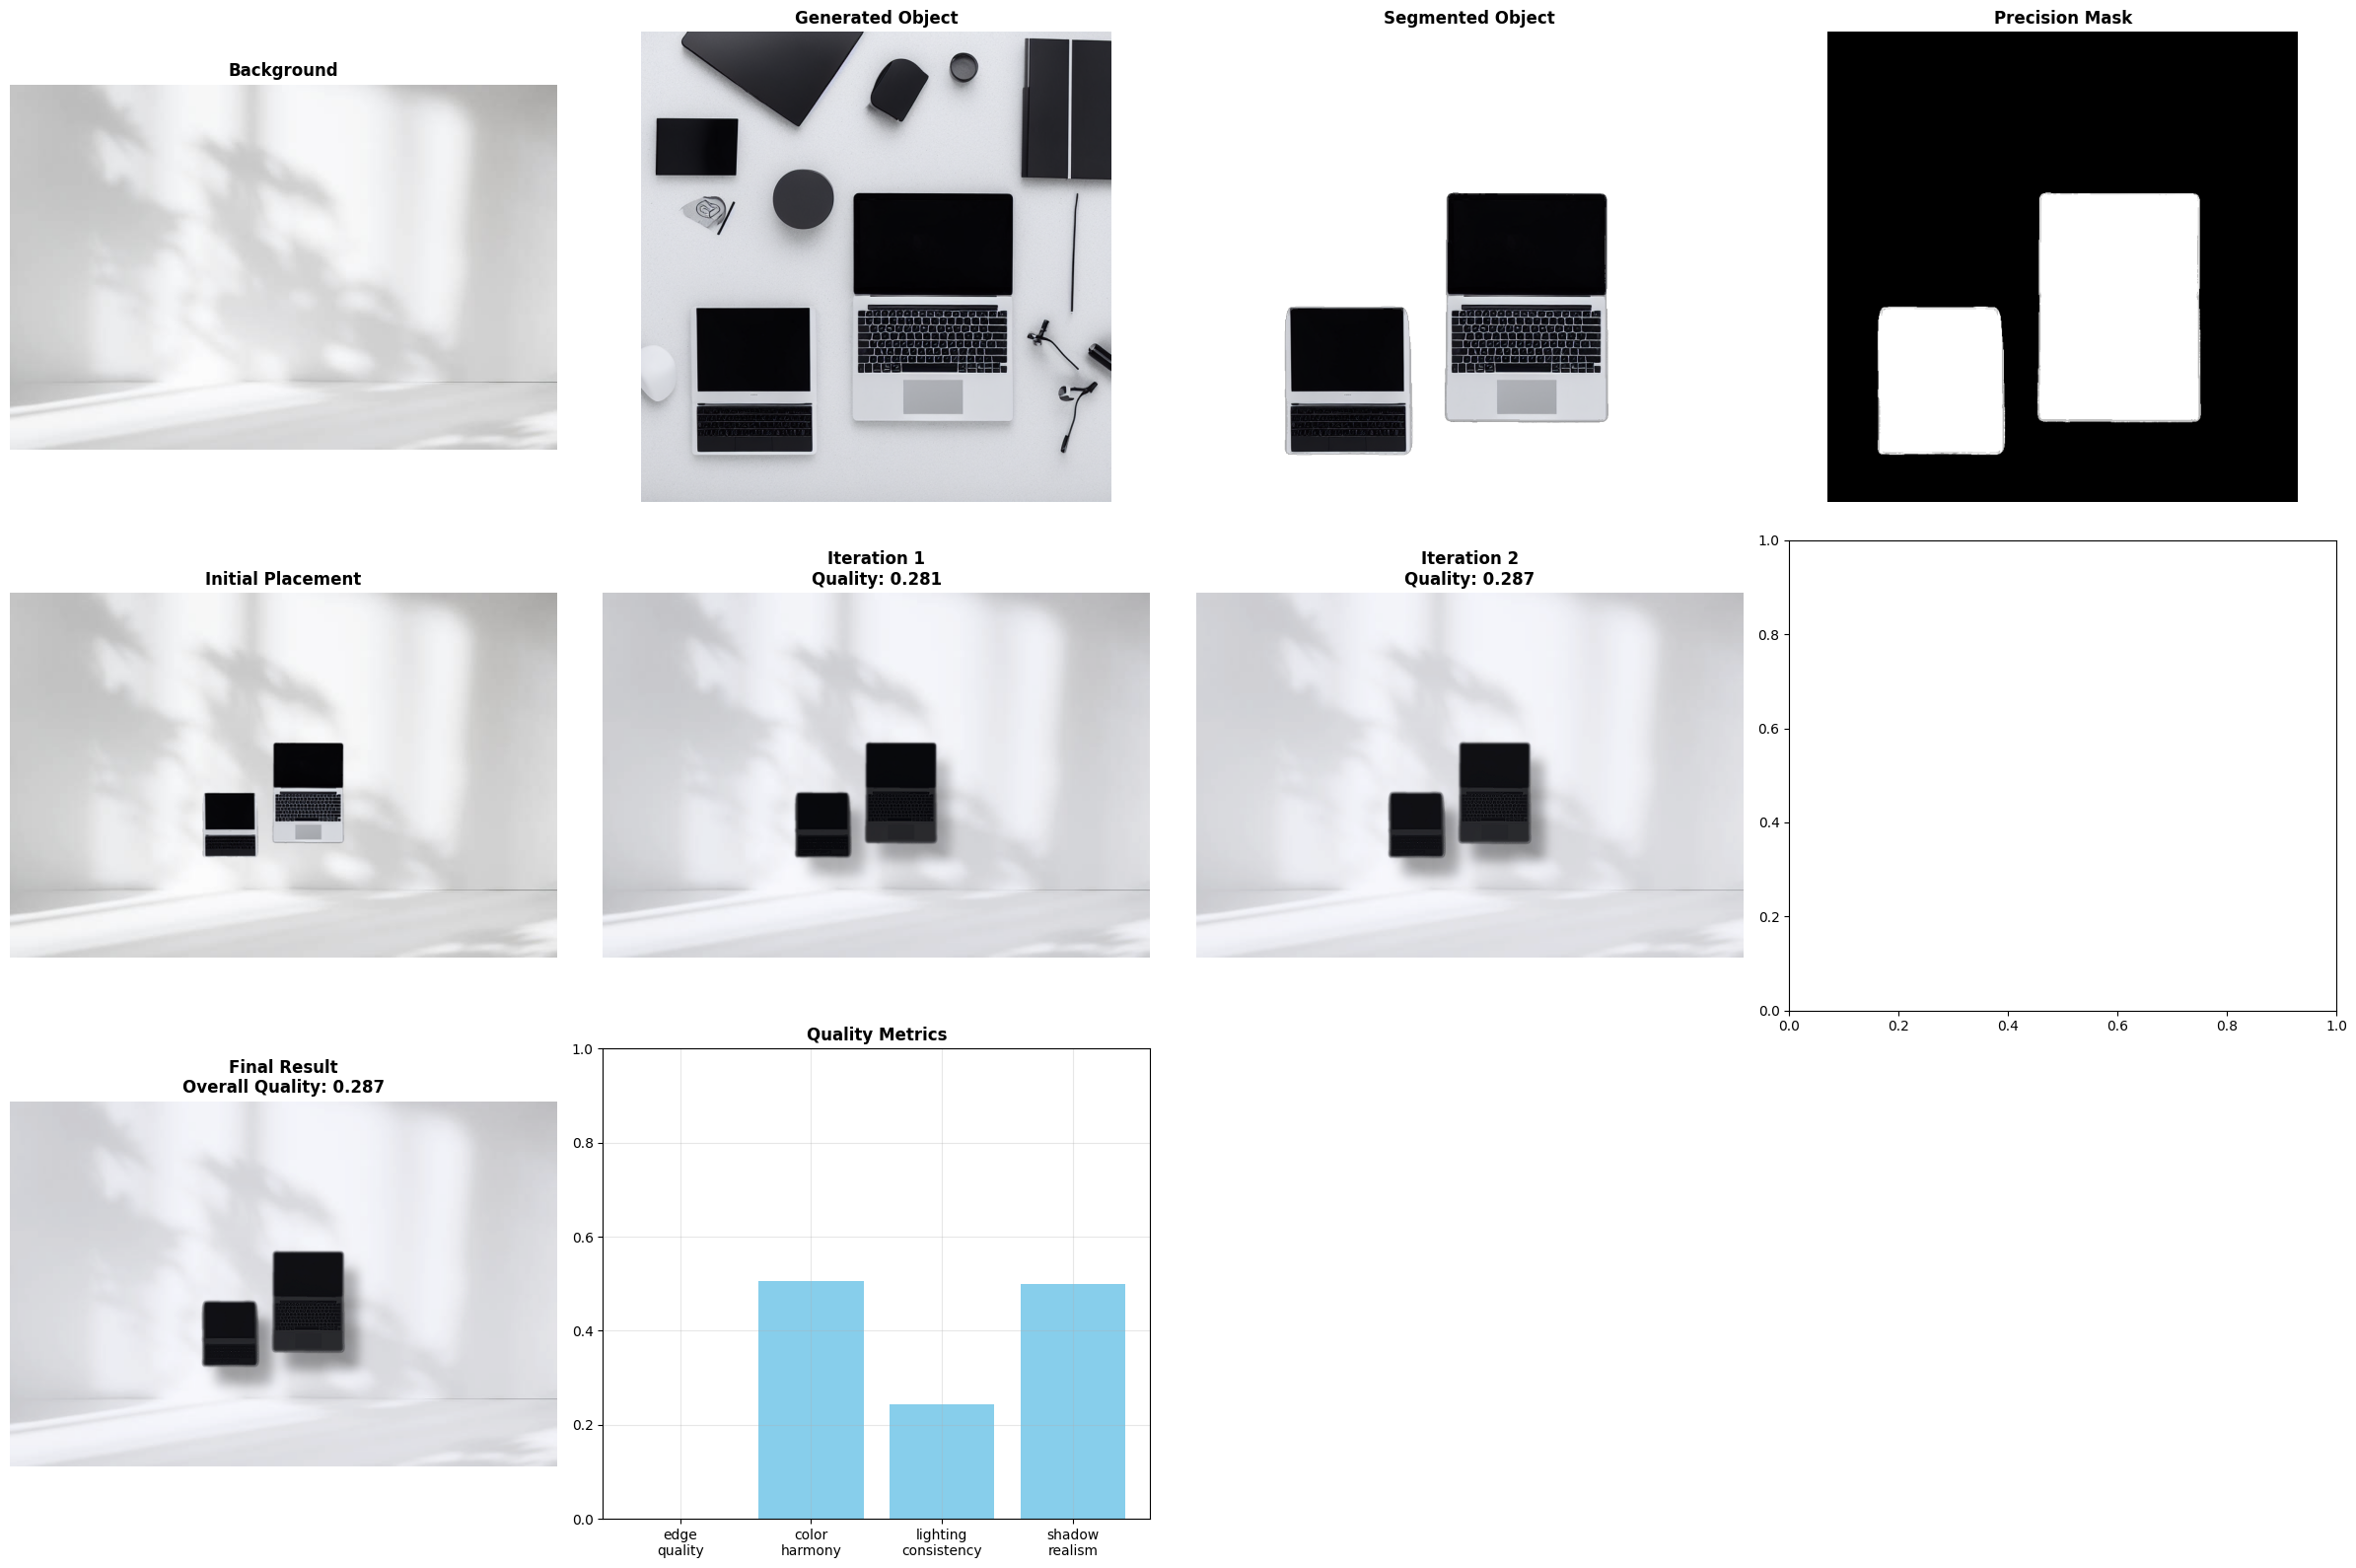


ENHANCED PIPELINE QUALITY REPORT

OVERALL QUALITY SCORE: 0.287/1.000

DETAILED METRICS:
├─ Edge Quality:           0.000
├─ Color Harmony:          0.506
├─ Lighting Consistency:   0.243
└─ Shadow Realism:         0.500

QUALITY ASSESSMENT: POOR
Interpretation: Significant blending issues detected

RECOMMENDations:
• Consider adjusting edge feathering parameters
• Increase color adaptation strength
• Adjust lighting matching parameters
• Fine-tune shadow generation settings

PLACEMENT INFO:
• Final scale: 0.30
• Position: (191, 89)


In [ ]:
def enhanced_demo():
    """Comprehensive demo of enhanced pipeline"""


    print("="*60)
    print("ENHANCED OBJECT BLENDING PIPELINE DEMO")
    print("="*60)


    # Initialize pipeline
    pipeline = EnhancedObjectBlendingPipeline()


    # Example parameters (update paths as needed)
    demo_configs = [
        {
            'prompt': 'a sleek black laptop which blends well in white background for product photography around a white wall',
            'background': '/content/white.jpg',  # Update path
            'position': None,
            'scale': 2,
            'seed': 123
        }
    ]


    for i, config in enumerate(demo_configs):
        print(f"\n{'='*40}")
        print(f"DEMO {i+1}: {config['prompt']}")
        print(f"{'='*40}")


        try:
            # Process with enhanced pipeline
            results = pipeline.process(
                text_prompt=config['prompt'],
                background_path=config['background'],
                position=config['position'],
                scale=config['scale'],
                seed=config['seed'],
                quality_iterations=2
            )


            # Visualize results
            pipeline.visualize_enhanced_results(results)


            # Generate quality report
            pipeline.generate_quality_report(results)


        except Exception as e:
            print(f"Error in demo {i+1}: {e}")
            print("Please ensure background image paths are correct.")


# =====================
# 8. MAIN EXECUTION
# =====================


if __name__ == "__main__":
    print("\n" + "="*60)
    print("ENHANCED OBJECT BLENDING PIPELINE READY!")
    print("="*60)


    print("\nKEY IMPROVEMENTS:")
    print("✓ Quality-matched object generation")
    print("✓ Multi-stage precision segmentation")
    print("✓ Intelligent placement with perspective")
    print("✓ Advanced lighting and shadow analysis")
    print("✓ Iterative quality improvement")
    print("✓ Comprehensive quality assessment")


    print("\nQUICK START:")
    print("1. Upload background images to your environment")
    print("2. Update image paths in enhanced_demo()")
    print("3. Run: enhanced_demo()")


    print("\nCUSTOM USAGE:")
    print("pipeline = EnhancedObjectBlendingPipeline()")
    print("results = pipeline.process('your prompt', 'background.jpg')")
    print("pipeline.visualize_enhanced_results(results)")


    # Uncomment to run demo
    enhanced_demo()
